In [53]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
pd.set_option('display.max_rows', None)
from sklearn.preprocessing import normalize

def loadFiles(path):
    furhat_files = []
    
    for filename in os.listdir(path):
        if filename.endswith('.csv'):
            src = filename
            furhat_files.append(src)
            
    return furhat_files

def returnFileGroup(lookup,furhat_pos_name):
    row = lookup[lookup['furhat_pose']==furhat_pos_name]
    fur = pd.read_csv('video_log_labels/furhat_csvs/'+row['furhat_pose'].tolist()[0])
    part = pd.read_csv('video_log_labels/participant_video_csvs/'+row['participant_pose'].tolist()[0])
    spee = pd.read_csv('video_log_labels/speech_csvs/'+row['speech'].tolist()[0])
    fs = pd.read_csv('video_log_labels/furhat_speech_csvs/'+row['furhat_speech'].tolist()[0])
    print('video_log_labels/participant_video_csvs/'+row['participant_pose'].tolist()[0])
    return fur, fs, part, spee

def matchTime(furhatpose, furhatspeech, particip, transc):
    try:
        time_video = float(transc[transc['DisplayText'].str.contains('Vad heter du och')]['Offset'].tolist()[0])
        time_log = float(furhatspeech[furhatspeech['value'].str.contains('text: Vad heter du')]['timestamp'].tolist()[0])
    except:
        try:
            time_video = float(transc[transc['DisplayText'].str.contains('Trevligt att')]['Offset'].tolist()[0])
            time_log = float(furhatspeech[furhatspeech['value'].str.contains('text: Trevligt att')]['timestamp'].tolist()[0])
        except:
            try:
                time_video = float(transc[transc['DisplayText'].str.contains('vad heter du?')]['Offset'].tolist()[0])
                time_log = float(furhatspeech[furhatspeech['value'].str.contains('text: Vad heter du')]['timestamp'].tolist()[0])
            except:
                time_video = float(transc[transc['DisplayText'].str.contains('Vad gör du och')]['Offset'].tolist()[0])
                time_log = float(furhatspeech[furhatspeech['value'].str.contains('text: Vad heter du')]['timestamp'].tolist()[0])
    time_video = 46.823
    print('video matched at '+str(time_video)+' to log at '+str(time_log))
    furhatspeech['timestamp'] = furhatspeech['timestamp'].astype(float)-time_log
    furhatpose['timestamp'] = furhatpose['timestamp']-time_log
    particip['time_elapsed (s)'] = particip['time_elapsed (s)']-time_video
    #print(particip)
    #particip.columns = 
    transc['Offset'] = transc['Offset'].astype(float)-time_video
    return furhatpose, furhatspeech, particip, transc, time_video


In [54]:
file_idx = 6 #choose index between 1 and 26 (not 7 because there is no 38 video) #18 #8 #10 #24 
speech = loadFiles('video_log_labels/speech_csvs/')
furhat = loadFiles('video_log_labels/furhat_csvs/')
furhat_speech = loadFiles('video_log_labels/furhat_speech_csvs/')
lookup = pd.DataFrame(pd.read_excel('video_log_labels/log_lookup.xlsx'))
print('analyzing ',furhat[file_idx])
furhat_pose, furhat_speech, participant, transcribe = returnFileGroup(lookup,furhat[file_idx])
#print(transcribe[['Offset','DisplayText']])
#print(participant[['time_elapsed (s)','left angle horizontal']])
#print(furhat_speech)
fp_adj, fs_adj, p_adj, t_adj, time_video_offset = matchTime(pd.DataFrame(furhat_pose), pd.DataFrame(furhat_speech).astype(str), pd.DataFrame(participant), pd.DataFrame(transcribe).astype(str))
#change aversion to straight
# for i in range(len(fp_adj.index)):
#     #print(fp_adj['y_pos'].iloc[i])
#     if fp_adj['y_pos'].iloc[i]==0.5899999737739563:
#         fp_adj['side'].iloc[i]='aversion'
#     if fp_adj['side'].iloc[i]=='Right':
#         fp_adj['side'].iloc[i]='Left'
#     if fp_adj['side'].iloc[i]=='Left':
#         fp_adj['side'].iloc[i]='Right'

analyzing  Oct-02-2020_16-47-18_mediation_108_Furhat.csv
video_log_labels/participant_video_csvs/10-02-2020-Furhat__108109.csv
video matched at 46.823 to log at 3.0141971111297607


In [55]:
data = pd.read_csv('video_log_labels/108_annotation.txt', sep='\t', header = None)
data.columns = ['gaze_subject', 'ignore','ignore2', 'begin_time','ignore4','end_time', 'ignore6', 'duration','gaze_object']
data = data.drop(['ignore','ignore2', 'ignore4','ignore6'],1)
data['encoded'] = np.where(data['gaze_object'] == 'Robot', 1, np.where(data['gaze_object'] == 'Other', -1, 0))
data['begin_time'] = data['begin_time'] - time_video_offset
data['end_time'] = data['end_time'] - time_video_offset
print(data)

    gaze_subject  begin_time  end_time  duration gaze_object  encoded
0     GazeOfLeft      -8.823    -7.573     1.250       Robot        1
1     GazeOfLeft      -7.564    -5.155     2.409      Tablet        0
2     GazeOfLeft      -5.155     2.653     7.808       Robot        1
3     GazeOfLeft       2.656     7.487     4.831       Other       -1
4     GazeOfLeft       7.501    19.459    11.958       Robot        1
5     GazeOfLeft      19.460    20.014     0.554      Tablet        0
6     GazeOfLeft      20.014    24.852     4.838       Robot        1
7     GazeOfLeft      24.852    26.838     1.986      Tablet        0
8     GazeOfLeft      26.838    47.275    20.437       Robot        1
9     GazeOfLeft      47.284    48.270     0.986      Tablet        0
10    GazeOfLeft      48.270    49.891     1.621       Robot        1
11    GazeOfLeft      49.891    51.086     1.195      Tablet        0
12    GazeOfLeft      51.086    53.924     2.838       Robot        1
13    GazeOfLeft    

In [56]:
left = data[data['gaze_subject']=='GazeOfRight']
left_robot_dur = left[left['gaze_object']=='Robot']['duration'].sum()
print(left_robot_dur)
left_other_dur = left[left['gaze_object']=='Other']['duration'].sum()
print(left_other_dur)
left_tablet_dur = left[left['gaze_object']=='Tablet']['duration'].sum()
print(left_tablet_dur)

446.144
83.172
299.69


In [57]:
right = data[data['gaze_subject']=='GazeOfLeft']
right_robot_dur = right[right['gaze_object']=='Robot']['duration'].sum()
print(right_robot_dur)
right_other_dur = right[right['gaze_object']=='Other']['duration'].sum()
print(right_other_dur)
right_tablet_dur = right[right['gaze_object']=='Tablet']['duration'].sum()
print(right_tablet_dur)

413.25699999999995
306.833
269.216


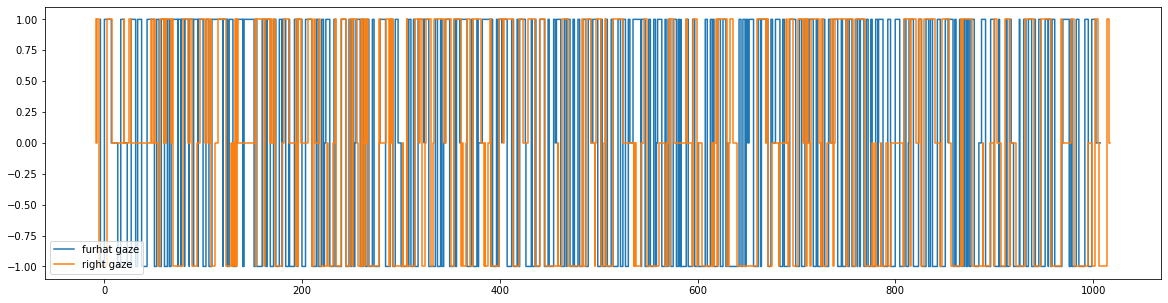

In [58]:
plt.figure(0,figsize=(20,5))
#print(fp_adj)
fp_adj['right_encoded'] = np.where(fp_adj['side'] == 'right', 1, np.where(fp_adj['side'] == 'left', -1, 0))
furhat_pose = np.array(fp_adj)
plt.step(furhat_pose[:,1],fp_adj['right_encoded'],label = 'furhat gaze')
plt.step(np.array(right['begin_time']),np.array(right['encoded']),label='right gaze')
#plt.step(np.array(left['begin_time']),np.array(left['encoded']),label='left gaze')
plt.legend()

In [ ]:
plt.figure(0,figsize=(20,5))
fp_adj['left_encoded'] = np.where(fp_adj['side'] == 'right', -1, np.where(fp_adj['side'] == 'left', 1, 0))
furhat_pose = np.array(fp_adj)
plt.step(furhat_pose[:,1],fp_adj['left_encoded'],label = 'furhat gaze')
#plt.step(np.array(right['begin_time']),np.array(right['encoded']),label='right gaze')
plt.step(np.array(left['begin_time']),np.array(left['encoded']),label='left gaze')
plt.legend()

#print(fp_adj)

In [93]:
from tqdm import tqdm
times = np.arange(0,969,.1)
furhat_by_time = []
change_dir_count = 0
fur_change = []
for time in tqdm(times):
    for row in range(len(fp_adj.index)-1):
        if (time >= fp_adj['timestamp'].iloc[row]) & (time <= fp_adj['timestamp'].iloc[row+1]):
            furhat_by_time.append([time,fp_adj['x_pos'].iloc[row],fp_adj['y_pos'].iloc[row],fp_adj['side'].iloc[row],fp_adj['left_encoded'].iloc[row],fp_adj['right_encoded'].iloc[row]])
        
for row in range(len(fp_adj.index)):        
    if fp_adj['side'].iloc[row] != fp_adj['side'].iloc[row-1]:
        change_dir_count += 1

for row in range(len(furhat_by_time.index)):  
    if furhat_by_time['side'].iloc[row] != furhat_by_time['side'].iloc[row-1]:
        fur_change.append(1)
    else:
        fur_change.append(0)
        
        
furhat_by_time = pd.DataFrame(furhat_by_time)
furhat_by_time.columns = ['time','x_pos','y_pos','side','left_encoded','right_encoded']
#furhat_by_time = right_by_time.drop('ignore',1)
print(furhat_by_time)     
print(change_dir_count/968.9*60)    
print(change_dir_count)

       time     x_pos     y_pos      side  left_encoded  right_encoded
0       0.0 -0.700000  0.000000      left             1             -1
1       0.1 -0.700000  0.000000      left             1             -1
2       0.2 -0.700000  0.000000      left             1             -1
3       0.3 -0.700000  0.000000      left             1             -1
4       0.4 -0.700000  0.000000      left             1             -1
5       0.5 -0.700000  0.000000      left             1             -1
6       0.6 -0.700000  0.000000      left             1             -1
7       0.7 -0.700000  0.000000      left             1             -1
8       0.8 -0.700000  0.000000      left             1             -1
9       0.9 -0.700000  0.000000      left             1             -1
10      1.0 -0.700000  0.000000      left             1             -1
11      1.1 -0.700000  0.000000      left             1             -1
12      1.2 -0.700000  0.000000      left             1             -1
13    

In [80]:
#proportion of furhat gaze for normalizing
left_time = furhat_by_time[furhat_by_time['side']=='left']['side'].count()
right_time = furhat_by_time[furhat_by_time['side']=='right']['side'].count()
straight_time = furhat_by_time[furhat_by_time['side']=='straight']['side'].count()
print(left_time/(left_time+right_time+straight_time))
print(right_time/(left_time+right_time+straight_time))
print(straight_time/(left_time+right_time+straight_time))

0.3462332301341589
0.5113519091847265
0.14241486068111456


In [81]:
from tqdm import tqdm
times = np.arange(0,1019,.1)
print(right)
right_by_time = []
change_dir_count = 0
right_change = []
for time in tqdm(times):
    for row in range(len(right.index)):
        if (time >= right['begin_time'].iloc[row]) & (time <= right['end_time'].iloc[row]):
            right_by_time.append([time,right['gaze_object'].iloc[row],right['encoded'].iloc[row]])
            
right_by_time = pd.DataFrame(right_by_time)
right_by_time.columns = ['time','gaze_object','encoded']

count = 0            
change_per_min = []           
for row in range(len(right_by_time.index)):
    print(right_by_time['time'].iloc[row])
    if right_by_time['time'].iloc[row] % 60.0 == 0.0:
        change_per_min.append(count)
        print("right_by_time['time'] % 60.0")
        count = 0
    if right_by_time['gaze_object'].iloc[row] != right_by_time['gaze_object'].iloc[row-1]:
        count+=1
        change_dir_count += 1
        right_change.append(1)
    else:
        right_change.append(0)
        
#right_by_time = right_by_time.drop('ignore',1)
print(right_by_time)
print(change_dir_count/1019.366*60)

  0%|                                                                              | 11/10190 [00:00<01:35, 107.07it/s]

    gaze_subject  begin_time  end_time  duration gaze_object  encoded
0     GazeOfLeft      -8.823    -7.573     1.250       Robot        1
1     GazeOfLeft      -7.564    -5.155     2.409      Tablet        0
2     GazeOfLeft      -5.155     2.653     7.808       Robot        1
3     GazeOfLeft       2.656     7.487     4.831       Other       -1
4     GazeOfLeft       7.501    19.459    11.958       Robot        1
5     GazeOfLeft      19.460    20.014     0.554      Tablet        0
6     GazeOfLeft      20.014    24.852     4.838       Robot        1
7     GazeOfLeft      24.852    26.838     1.986      Tablet        0
8     GazeOfLeft      26.838    47.275    20.437       Robot        1
9     GazeOfLeft      47.284    48.270     0.986      Tablet        0
10    GazeOfLeft      48.270    49.891     1.621       Robot        1
11    GazeOfLeft      49.891    51.086     1.195      Tablet        0
12    GazeOfLeft      51.086    53.924     2.838       Robot        1
13    GazeOfLeft    

100%|███████████████████████████████████████████████████████████████████████████| 10190/10190 [01:06<00:00, 152.12it/s]


0.0
right_by_time['time'] % 60.0
0.1
0.2
0.30000000000000004
0.4
0.5
0.6000000000000001
0.7000000000000001
0.8
0.9
1.0
1.1
1.2000000000000002
1.3
1.4000000000000001
1.5
1.6
1.7000000000000002
1.8
1.9000000000000001
2.0
2.1
2.2
2.3000000000000003
2.4000000000000004
2.5
2.6
2.7
2.8000000000000003
2.9000000000000004
3.0
3.1
3.2
3.3000000000000003
3.4000000000000004
3.5
3.6
3.7
3.8000000000000003
3.9000000000000004
4.0
4.1000000000000005
4.2
4.3
4.4
4.5
4.6000000000000005
4.7
4.800000000000001
4.9
5.0
5.1000000000000005
5.2
5.300000000000001
5.4
5.5
5.6000000000000005
5.7
5.800000000000001
5.9
6.0
6.1000000000000005
6.2
6.300000000000001
6.4
6.5
6.6000000000000005
6.7
6.800000000000001
6.9
7.0
7.1000000000000005
7.2
7.300000000000001
7.4
7.6000000000000005
7.7
7.800000000000001
7.9
8.0
8.1
8.200000000000001
8.3
8.4
8.5
8.6
8.700000000000001
8.8
8.9
9.0
9.1
9.200000000000001
9.3
9.4
9.5
9.600000000000001
9.700000000000001
9.8
9.9
10.0
10.100000000000001
10.200000000000001
10.3
10.4
10.5
10.

118.7
118.80000000000001
118.9
119.0
119.10000000000001
119.2
119.30000000000001
119.4
119.5
119.60000000000001
119.7
119.80000000000001
119.9
120.0
right_by_time['time'] % 60.0
120.10000000000001
120.2
120.30000000000001
120.4
120.5
120.60000000000001
120.7
120.80000000000001
120.9
121.0
121.10000000000001
121.2
121.30000000000001
121.4
121.5
121.60000000000001
121.7
121.80000000000001
121.9
122.0
122.10000000000001
122.2
122.30000000000001
122.4
122.5
122.60000000000001
122.7
122.80000000000001
122.9
123.0
123.10000000000001
123.2
123.30000000000001
123.4
123.5
123.60000000000001
123.7
123.80000000000001
123.9
124.0
124.10000000000001
124.2
124.30000000000001
124.4
124.5
124.60000000000001
124.7
124.80000000000001
124.9
125.0
125.10000000000001
125.2
125.30000000000001
125.4
125.5
125.60000000000001
125.7
125.80000000000001
125.9
126.0
126.10000000000001
126.2
126.30000000000001
126.4
126.5
126.60000000000001
126.7
126.80000000000001
126.9
127.0
127.10000000000001
127.2
127.300000000

221.8
221.9
222.0
222.10000000000002
222.20000000000002
222.3
222.4
222.5
222.60000000000002
222.70000000000002
222.8
222.9
223.0
223.10000000000002
223.20000000000002
223.3
223.4
223.5
223.60000000000002
223.70000000000002
223.8
223.9
224.0
224.10000000000002
224.20000000000002
224.3
224.4
224.5
224.60000000000002
224.70000000000002
224.8
224.9
225.0
225.10000000000002
225.20000000000002
225.3
225.4
225.5
225.60000000000002
225.70000000000002
225.8
225.9
226.0
226.10000000000002
226.20000000000002
226.3
226.4
226.5
226.60000000000002
226.70000000000002
226.8
226.9
227.0
227.10000000000002
227.20000000000002
227.3
227.4
227.5
227.60000000000002
227.70000000000002
227.8
227.9
228.0
228.10000000000002
228.20000000000002
228.3
228.4
228.5
228.60000000000002
228.70000000000002
228.8
228.9
229.0
229.10000000000002
229.20000000000002
229.3
229.4
229.5
229.60000000000002
229.70000000000002
229.8
229.9
230.0
230.10000000000002
230.20000000000002
230.3
230.4
230.5
230.60000000000002
230.7000000

321.5
321.6
321.70000000000005
321.8
321.90000000000003
322.0
322.1
322.20000000000005
322.3
322.40000000000003
322.5
322.6
322.70000000000005
322.8
322.90000000000003
323.0
323.1
323.20000000000005
323.3
323.40000000000003
323.5
323.6
323.70000000000005
323.8
323.90000000000003
324.0
324.1
324.20000000000005
324.3
324.40000000000003
324.5
324.6
324.70000000000005
324.8
324.90000000000003
325.0
325.1
325.20000000000005
325.3
325.40000000000003
325.5
325.6
325.70000000000005
325.8
325.90000000000003
326.0
326.1
326.20000000000005
326.3
326.40000000000003
326.5
326.6
326.70000000000005
326.8
326.90000000000003
327.0
327.1
327.20000000000005
327.3
327.40000000000003
327.5
327.6
327.70000000000005
327.8
327.90000000000003
328.0
328.1
328.20000000000005
328.3
328.40000000000003
328.5
328.6
328.70000000000005
328.8
328.90000000000003
329.0
329.1
329.20000000000005
329.3
329.40000000000003
329.5
329.6
329.70000000000005
329.8
329.90000000000003
330.0
330.1
330.20000000000005
330.3
330.4000000

434.70000000000005
434.8
434.90000000000003
435.0
435.1
435.20000000000005
435.3
435.40000000000003
435.5
435.6
435.70000000000005
435.8
435.90000000000003
436.0
436.1
436.20000000000005
436.3
436.40000000000003
436.5
436.6
436.70000000000005
436.8
436.90000000000003
437.0
437.1
437.20000000000005
437.3
437.40000000000003
437.5
437.6
437.70000000000005
437.8
437.90000000000003
438.0
438.1
438.20000000000005
438.3
438.40000000000003
438.5
438.6
438.70000000000005
438.8
438.90000000000003
439.0
439.1
439.20000000000005
439.3
439.40000000000003
439.5
439.6
439.70000000000005
439.8
439.90000000000003
440.0
440.1
440.20000000000005
440.3
440.40000000000003
440.5
440.6
440.70000000000005
440.8
440.90000000000003
441.0
441.1
441.20000000000005
441.3
441.40000000000003
441.5
441.6
441.70000000000005
441.8
441.90000000000003
442.0
442.1
442.20000000000005
442.3
442.40000000000003
442.5
442.6
442.70000000000005
442.8
442.90000000000003
443.0
443.1
443.20000000000005
443.3
443.40000000000003
443.

549.9
550.0
550.1
550.2
550.3000000000001
550.4
550.5
550.6
550.7
550.8000000000001
550.9
551.0
551.1
551.2
551.3000000000001
551.4
551.5
551.6
551.7
551.8000000000001
551.9
552.0
552.1
552.2
552.3000000000001
552.4
552.5
552.6
552.7
552.8000000000001
552.9
553.0
553.1
553.2
553.3000000000001
553.4
553.5
553.6
553.7
553.8000000000001
553.9
554.0
554.1
554.2
554.3000000000001
554.4
554.5
554.6
554.7
554.8000000000001
554.9
555.0
555.1
555.2
555.3000000000001
555.4
555.5
555.6
555.7
555.8000000000001
555.9
556.0
556.1
556.2
556.3000000000001
556.4
556.5
556.6
556.7
556.8000000000001
556.9
557.0
557.1
557.2
557.3000000000001
557.4
557.5
557.6
557.7
557.8000000000001
557.9
558.0
558.1
558.2
558.3000000000001
558.4
558.5
558.6
558.7
558.8000000000001
558.9
559.0
559.1
559.2
559.3000000000001
559.4
559.5
559.6
559.7
559.8000000000001
559.9
560.0
560.1
560.2
560.3000000000001
560.4
560.5
560.6
560.7
560.8000000000001
560.9
561.0
561.1
561.2
561.3000000000001
561.4
561.5
561.6
561.7
561.800000

677.1
677.2
677.3000000000001
677.4000000000001
677.5
677.6
677.7
677.8000000000001
677.9000000000001
678.0
678.1
678.2
678.3000000000001
678.4000000000001
678.5
678.6
678.7
678.8000000000001
678.9000000000001
679.0
679.1
679.2
679.3000000000001
679.4000000000001
679.5
679.6
679.7
679.8000000000001
679.9000000000001
680.0
680.1
680.2
680.3000000000001
680.4000000000001
680.5
680.6
680.7
680.8000000000001
680.9000000000001
681.0
681.1
681.2
681.3000000000001
681.4000000000001
681.5
681.6
681.7
681.8000000000001
681.9000000000001
682.0
682.1
682.2
682.3000000000001
682.4000000000001
682.5
682.6
682.7
682.8000000000001
682.9000000000001
683.0
683.1
683.2
683.3000000000001
683.4000000000001
683.5
683.6
683.7
683.8000000000001
683.9000000000001
684.0
684.1
684.2
684.3000000000001
684.4000000000001
684.5
684.6
684.7
684.8000000000001
684.9000000000001
685.0
685.1
685.2
685.3000000000001
685.4000000000001
685.5
685.6
685.7
685.8000000000001
685.9000000000001
686.0
686.1
686.2
686.300000000000

776.8000000000001
776.9000000000001
777.0
777.1
777.2
777.3000000000001
777.4000000000001
777.5
777.6
777.7
777.8000000000001
777.9000000000001
778.0
778.1
778.2
778.3000000000001
778.4000000000001
778.5
778.6
778.7
778.8000000000001
778.9000000000001
779.0
779.1
779.2
779.3000000000001
779.4000000000001
779.5
779.6
779.7
779.8000000000001
779.9000000000001
780.0
right_by_time['time'] % 60.0
780.1
780.2
780.3000000000001
780.4000000000001
780.5
780.6
780.7
780.8000000000001
780.9000000000001
781.0
781.1
781.2
781.3000000000001
781.4000000000001
781.5
781.6
781.7
781.8000000000001
781.9000000000001
782.0
782.1
782.2
782.3000000000001
782.4000000000001
782.5
782.6
782.7
782.8000000000001
782.9000000000001
783.0
783.1
783.2
783.3000000000001
783.4000000000001
783.5
783.6
783.7
783.8000000000001
783.9000000000001
784.0
784.1
784.2
784.3000000000001
784.4000000000001
784.5
784.6
784.7
784.8000000000001
784.9000000000001
785.0
785.1
785.2
785.3000000000001
785.4000000000001
785.5
785.6
785.7

908.4000000000001
908.5
908.6
908.7
908.8000000000001
908.9000000000001
909.0
909.1
909.2
909.3000000000001
909.4000000000001
909.5
909.6
909.7
909.8000000000001
909.9000000000001
910.0
910.1
910.2
910.3000000000001
910.4000000000001
910.5
910.6
910.7
910.8000000000001
910.9000000000001
911.0
911.1
911.2
911.3000000000001
911.4000000000001
911.5
911.6
911.7
911.8000000000001
911.9000000000001
912.0
912.1
912.2
912.3000000000001
912.4000000000001
912.5
912.6
912.7
912.8000000000001
912.9000000000001
913.0
913.1
913.2
913.3000000000001
913.4000000000001
913.5
913.6
913.7
913.8000000000001
913.9000000000001
914.0
914.1
914.2
914.3000000000001
914.4000000000001
914.5
914.6
914.7
914.8000000000001
914.9000000000001
915.0
915.1
915.2
915.3000000000001
915.4000000000001
915.5
915.6
915.7
915.8000000000001
915.9000000000001
916.0
916.1
916.2
916.3000000000001
916.4000000000001
916.5
916.6
916.7
916.8000000000001
916.9000000000001
917.0
917.1
917.2
917.3000000000001
917.4000000000001
917.5
917.

         time gaze_object  encoded
0         0.0       Robot        1
1         0.1       Robot        1
2         0.2       Robot        1
3         0.3       Robot        1
4         0.4       Robot        1
5         0.5       Robot        1
6         0.6       Robot        1
7         0.7       Robot        1
8         0.8       Robot        1
9         0.9       Robot        1
10        1.0       Robot        1
11        1.1       Robot        1
12        1.2       Robot        1
13        1.3       Robot        1
14        1.4       Robot        1
15        1.5       Robot        1
16        1.6       Robot        1
17        1.7       Robot        1
18        1.8       Robot        1
19        1.9       Robot        1
20        2.0       Robot        1
21        2.1       Robot        1
22        2.2       Robot        1
23        2.3       Robot        1
24        2.4       Robot        1
25        2.5       Robot        1
26        2.6       Robot        1
27        2.7       

In [63]:
#change standard deviation
print(np.std(change_per_min[1:]))
print(change_per_min)

4.311594107751795
[0, 13, 20, 21, 22, 25, 17, 19, 9, 18, 16, 15, 23, 17, 18, 14, 10]


In [86]:
from tqdm import tqdm
times = np.arange(0,1019,.1)
left_by_time = []
change_dir_count = 0
left_change = []
for time in tqdm(times):
    for row in range(len(left.index)):
        if (time >= left['begin_time'].iloc[row]) & (time <= left['end_time'].iloc[row]):
            left_by_time.append([time,left['gaze_object'].iloc[row],left['encoded'].iloc[row]])
            
left_by_time = pd.DataFrame(left_by_time)
left_by_time.columns = ['time','gaze_object','encoded']

count = 0            
change_per_min = []           
for row in range(len(left_by_time.index)):
    #print(left_by_time['time'].iloc[row])
    if left_by_time['time'].iloc[row] % 60.0 == 0.0:
        change_per_min.append(count)
        #print("right_by_time['time'] % 60.0")
        count = 0
    if left_by_time['gaze_object'].iloc[row] != left_by_time['gaze_object'].iloc[row-1]:
        count+=1
        change_dir_count += 1
        left_change.append(1)
    else:
        left_change.append(0)
        
#left_by_time = left_by_time.drop('ignore',1)
print(left_by_time)
print(change_dir_count/1019.366*60)

100%|███████████████████████████████████████████████████████████████████████████| 10190/10190 [01:25<00:00, 119.52it/s]


         time gaze_object  encoded
0         0.0       Robot        1
1         0.1       Robot        1
2         0.2       Robot        1
3         0.3       Robot        1
4         0.4       Robot        1
5         0.5       Robot        1
6         0.6       Robot        1
7         0.7       Robot        1
8         0.8       Robot        1
9         0.9       Robot        1
10        1.0       Robot        1
11        1.1       Robot        1
12        1.2       Robot        1
13        1.3       Robot        1
14        1.4       Robot        1
15        1.5       Robot        1
16        1.6       Robot        1
17        1.7       Robot        1
18        1.8       Robot        1
19        1.9       Robot        1
20        2.0       Robot        1
21        2.1       Robot        1
22        2.2       Robot        1
23        2.3       Robot        1
24        2.4       Robot        1
25        2.5       Robot        1
26        2.6       Robot        1
27        2.7       

In [65]:
#calculate standard deviation
print(np.std(change_per_min[1:]))
print(change_per_min)

4.792164829176893
[0, 11, 26, 19, 29, 27, 24, 23, 22, 20, 20, 16, 20, 24, 19, 12, 19]


In [66]:
#right participant at participant
part_tablet = 0
part_away = 0
part_other = 0
part_robot = 0
for i in range(9600):
    if (furhat_by_time['side'].iloc[i] == 'right') & (right_by_time['gaze_object'].iloc[i] == 'Robot'):
        part_robot +=1
    if (furhat_by_time['side'].iloc[i] == 'right') & (right_by_time['gaze_object'].iloc[i] == 'Tablet'):
        part_tablet +=1
    if (furhat_by_time['side'].iloc[i] == 'right') & (right_by_time['gaze_object'].iloc[i] == 'Away'):
        part_away +=1    
    if (furhat_by_time['side'].iloc[i] == 'right') & (right_by_time['gaze_object'].iloc[i] == 'Other'):
        part_other +=1  
print(part_tablet/(part_tablet+part_away+part_other+part_robot))
print(part_away/(part_tablet+part_away+part_other+part_robot))
print(part_other/(part_tablet+part_away+part_other+part_robot))
print(part_robot/(part_tablet+part_away+part_other+part_robot))
print(part_tablet)
print(part_away)
print(part_other)
print(part_robot)

0.23205342237061768
0.03151085141903172
0.27525041736227046
0.4611853088480801
1112
151
1319
2210


In [67]:
#right participant gaze other
other_tablet = 0
other_away = 0
other_other = 0
other_robot = 0
for i in range(9600):
    if (furhat_by_time['side'].iloc[i] == 'left') & (right_by_time['gaze_object'].iloc[i] == 'Robot'):
        other_robot +=1
    if (furhat_by_time['side'].iloc[i] == 'left') & (right_by_time['gaze_object'].iloc[i] == 'Tablet'):
        other_tablet +=1
    if (furhat_by_time['side'].iloc[i] == 'left') & (right_by_time['gaze_object'].iloc[i] == 'Away'):
        other_away +=1    
    if (furhat_by_time['side'].iloc[i] == 'left') & (right_by_time['gaze_object'].iloc[i] == 'Other'):
        other_other +=1  
print(other_tablet/(other_tablet+other_away+other_other+other_robot))
print(other_away/(other_tablet+other_away+other_other+other_robot))
print(other_other/(other_tablet+other_away+other_other+other_robot))
print(other_robot/(other_tablet+other_away+other_other+other_robot))
print(other_tablet)
print(other_away)
print(other_other)
print(other_robot)

0.1458651205370766
0.011290814769606347
0.4394263045468416
0.40341776014647546
478
37
1440
1322


In [68]:
#left participant
part_tablet = 0
part_away = 0
part_other = 0
part_robot = 0
for i in range(9600):
    if (furhat_by_time['side'].iloc[i] == 'left') & (left_by_time['gaze_object'].iloc[i] == 'Robot'):
        part_robot +=1
    if (furhat_by_time['side'].iloc[i] == 'left') & (left_by_time['gaze_object'].iloc[i] == 'Tablet'):
        part_tablet +=1
    if (furhat_by_time['side'].iloc[i] == 'left') & (left_by_time['gaze_object'].iloc[i] == 'Away'):
        part_away +=1    
    if (furhat_by_time['side'].iloc[i] == 'left') & (left_by_time['gaze_object'].iloc[i] == 'Other'):
        part_other +=1  
print(part_tablet/(part_tablet+part_away+part_other+part_robot))
print(part_away/(part_tablet+part_away+part_other+part_robot))
print(part_other/(part_tablet+part_away+part_other+part_robot))
print(part_robot/(part_tablet+part_away+part_other+part_robot))
print(part_tablet)
print(part_away)
print(part_other)
print(part_robot)

0.18090298962782184
0.2141549725442343
0.06040268456375839
0.5445393532641855
593
702
198
1785


In [69]:
#right participant
other_tablet = 0
other_away = 0
other_other = 0
other_robot = 0
for i in range(9600):
    if (furhat_by_time['side'].iloc[i] == 'right') & (left_by_time['gaze_object'].iloc[i] == 'Robot'):
        other_robot +=1
    if (furhat_by_time['side'].iloc[i] == 'right') & (left_by_time['gaze_object'].iloc[i] == 'Tablet'):
        other_tablet +=1
    if (furhat_by_time['side'].iloc[i] == 'right') & (left_by_time['gaze_object'].iloc[i] == 'Away'):
        other_away +=1    
    if (furhat_by_time['side'].iloc[i] == 'right') & (left_by_time['gaze_object'].iloc[i] == 'Other'):
        other_other +=1  
print(other_tablet/(other_tablet+other_away+other_other+other_robot))
print(other_away/(other_tablet+other_away+other_other+other_robot))
print(other_other/(other_tablet+other_away+other_other+other_robot))
print(other_robot/(other_tablet+other_away+other_other+other_robot))
print(other_tablet)
print(other_away)
print(other_other)
print(other_robot)

0.2857441035274473
0.17011062408682948
0.10999791275307869
0.43414735963264456
1369
815
527
2080


In [99]:
#aversion + right
aversion_tablet = 0
aversion_away = 0
aversion_other = 0
aversion_robot = 0
for i in range(9600):
    if (furhat_by_time['side'].iloc[i] == ('aversion' or 'straight')) & (right_by_time['gaze_object'].iloc[i] == 'Robot'):
        aversion_robot +=1
    if (furhat_by_time['side'].iloc[i] == ('aversion' or 'straight')) & (right_by_time['gaze_object'].iloc[i] == 'Tablet'):
        aversion_tablet +=1
    if (furhat_by_time['side'].iloc[i] == ('aversion' or 'straight')) & (right_by_time['gaze_object'].iloc[i] == 'Away'):
        aversion_away +=1    
    if (furhat_by_time['side'].iloc[i] == ('aversion' or 'straight')) & (right_by_time['gaze_object'].iloc[i] == 'Other'):
        aversion_other +=1  
# print(part_tablet/(part_tablet+part_away+part_other+part_robot))
# print(part_away/(part_tablet+part_away+part_other+part_robot))
# print(part_other/(part_tablet+part_away+part_other+part_robot))
# print(part_robot/(part_tablet+part_away+part_other+part_robot))
# print(aversion_tablet)
# print(aversion_away)
# print(aversion_other)
# print(aversion_robot)

In [100]:
#aversion + left
aversion_tablet = 0
aversion_away = 0
aversion_other = 0
aversion_robot = 0
for i in range(9600):
    if (furhat_by_time['side'].iloc[i] == ('aversion' or 'straight')) & (left_by_time['gaze_object'].iloc[i] == 'Robot'):
        aversion_robot +=1
    if (furhat_by_time['side'].iloc[i] == ('aversion' or 'straight')) & (left_by_time['gaze_object'].iloc[i] == 'Tablet'):
        aversion_tablet +=1
    if (furhat_by_time['side'].iloc[i] == ('aversion' or 'straight')) & (left_by_time['gaze_object'].iloc[i] == 'Away'):
        aversion_away +=1    
    if (furhat_by_time['side'].iloc[i] == ('aversion' or 'straight')) & (left_by_time['gaze_object'].iloc[i] == 'Other'):
        aversion_other +=1  
# print(part_tablet/(part_tablet+part_away+part_other+part_robot))
# print(part_away/(part_tablet+part_away+part_other+part_robot))
# print(part_other/(part_tablet+part_away+part_other+part_robot))
# print(part_robot/(part_tablet+part_away+part_other+part_robot))
# print(aversion_tablet)
# print(aversion_away)
# print(aversion_other)
# print(aversion_robot)